# Project 3: Subreddit Differentiation

## Problem Statement: 
The purpose of this project is to create a model that can classify between two different subreddits accurately. I have pulled data from two subreddits, 'showerthoughts' and 'stonerphilosophy'. We eventually settle on two different kinds of models, a multinomial naive bayes and a logisitic regression. In the Code directory of this repo, you can see other models that I considered. I settled on the multinomial naive bayes and logisitic regression models because I wanted my results to be interpretable. Both models do have slightly lower accuracy scores, but only by a few percentages.

## Executive Summary

### Table of Contents:
- [The Data](#The-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Sentiment Analysis](#Sentiment-Analysis)
- [Modeling](#Modeling)
- [Model Evaluation](#Model-Evaluation)
- [Conclusions](#Conclusions)

All libraries and modules used

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.pipeline import Pipeline
from nltk import word_tokenize          
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns
from sklearn.metrics import roc_auc_score


## The Data
We got the subreddit data using api pushshifts and then saved the gathered data into a csv so we could easily import it from the repo. If you would like to see exactly how I recquired the data, the code is found in the 'Getting the Data' directory.

In [3]:
#Import the data
df = pd.read_csv('../Data/final.csv')

## Exploratory Analysis

Make sure we have 2,000 rows, 1000 for each subreddit

In [3]:
df.shape

(2000, 6)

In [4]:
df.columns

Index(['created_utc', 'title', 'selftext', 'subreddit', 'permalink', 'author'], dtype='object')

In [5]:
df['subreddit'].value_counts()

StonerPhilosophy    1000
Showerthoughts      1000
Name: subreddit, dtype: int64

As desired, we have balanced classes of our target variable.

In [6]:
df.isnull().sum()

created_utc      0
title            0
selftext       825
subreddit        0
permalink        0
author           0
dtype: int64

This is telling us that there are 825 (a good amount) of null values for selftext. However, we won't worry about that now because 'selftext' refers to comments and that's not what we are focused on.

In [7]:
df['author'].unique

<bound method Series.unique of 0            SelfRefMeta
1               AV8ORboi
2           -skyfire370-
3       rslashredditor91
4                 urfear
              ...       
1995         lucienbeats
1996         mapsandnaps
1997             dirttan
1998           [deleted]
1999             B_Nitch
Name: author, Length: 2000, dtype: object>

This is surprising. This tells us that there is no overlap between authors but also that we have not pulled data that some author may have posted twice on the same reddit. I would've thought that there'd be at least one author posting multiple times in the same subreddit.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
created_utc    2000 non-null int64
title          2000 non-null object
selftext       1175 non-null object
subreddit      2000 non-null object
permalink      2000 non-null object
author         2000 non-null object
dtypes: int64(1), object(5)
memory usage: 93.9+ KB


### 1. Creating a word count column

My initial belief is that shower thought posts will be shorter than stoner philosophy posts. The following code will see if that's the case.

In [9]:
df['word_count'] = [len(x.split()) for x in df['title']]

In [10]:
df.groupby('subreddit')['word_count'].mean()

subreddit
Showerthoughts      15.012
StonerPhilosophy    11.749
Name: word_count, dtype: float64

This is super interesting because it's the opposite of my assumption. Seems that on average shower thoughts are longer than stoner thoughts.

### 2. Finding the most common word for each subreddit

In [11]:
#create a function that will convert every title into a list of words so we can call 'most common'
def pop_word(column):
    words = []
    for i in column:
        i = i.split()
        words.extend(i)
    return words

In [12]:
#looks like a list of lists
word = pop_word(df['title'])

In [13]:
counter1 = Counter(word)

In [14]:
#These are the most common words in all of the titles, including both subreddits.
counter1.most_common()

[('the', 988),
 ('a', 739),
 ('is', 581),
 ('to', 546),
 ('of', 525),
 ('and', 403),
 ('you', 384),
 ('in', 379),
 ('I', 333),
 ('are', 274),
 ('if', 218),
 ('that', 217),
 ('be', 208),
 ('it', 205),
 ('on', 182),
 ('we', 180),
 ('just', 177),
 ('What', 173),
 ('have', 159),
 ('If', 154),
 ('for', 150),
 ('your', 146),
 ('The', 142),
 ('would', 135),
 ('but', 130),
 ('when', 121),
 ('like', 117),
 ('with', 117),
 ('they', 107),
 ('people', 106),
 ('as', 105),
 ('all', 103),
 ('do', 103),
 ('my', 99),
 ('an', 93),
 ('not', 92),
 ('at', 90),
 ('was', 88),
 ('or', 86),
 ('this', 82),
 ('can', 78),
 ('how', 77),
 ('our', 75),
 ('will', 75),
 ('one', 74),
 ('from', 74),
 ('think', 73),
 ('what', 73),
 ('more', 71),
 ('only', 68),
 ('who', 67),
 ('their', 67),
 ('know', 67),
 ('so', 65),
 ('could', 63),
 ('time', 63),
 ('by', 60),
 ('because', 60),
 ('out', 60),
 ('How', 60),
 ('up', 57),
 ('about', 54),
 ('there', 53),
 ('person', 53),
 ('get', 53),
 ('A', 52),
 ('life', 52),
 ('were', 52),

My opinion is that the 'interesting' top words are: I, we, your, people. I think this says that we, as people, are mainly interested in things that relate to us versus different topics. This is to be expected. To complete my exploratory analysis, I'm going to examine the most popular words of each subreddit.

#### Shower Thoughts Common Words

In [15]:
temp1 = pd.read_csv('../Data/shower_final.csv')

In [16]:
temp1_a = pop_word(temp1['title'])

In [17]:
counter2 = Counter(temp1_a)

In [18]:
counter2.most_common()

[('the', 581),
 ('a', 431),
 ('is', 312),
 ('of', 295),
 ('to', 293),
 ('and', 223),
 ('in', 219),
 ('you', 205),
 ('I', 176),
 ('are', 147),
 ('it', 134),
 ('if', 134),
 ('be', 127),
 ('that', 126),
 ('just', 111),
 ('What', 107),
 ('have', 106),
 ('we', 103),
 ('If', 102),
 ('on', 95),
 ('for', 95),
 ('would', 91),
 ('your', 86),
 ('The', 82),
 ('but', 77),
 ('when', 75),
 ('people', 74),
 ('they', 73),
 ('with', 62),
 ('my', 61),
 ('as', 60),
 ('like', 59),
 ('an', 59),
 ('at', 58),
 ('all', 56),
 ('was', 56),
 ('not', 54),
 ('do', 54),
 ('can', 50),
 ('will', 49),
 ('how', 48),
 ('who', 46),
 ('their', 46),
 ('more', 45),
 ('from', 43),
 ('know', 42),
 ('person', 40),
 ('or', 40),
 ('could', 40),
 ('by', 39),
 ('never', 38),
 ('only', 36),
 ('because', 36),
 ('out', 36),
 ('time', 36),
 ('what', 36),
 ('get', 35),
 ('than', 35),
 ('this', 34),
 ('actually', 34),
 ('How', 34),
 ('one', 33),
 ('same', 33),
 ('then', 33),
 ('think', 31),
 ('were', 31),
 ('so', 31),
 ('many', 31),
 ('t

Common words in 'shower thoughts': you, I, What (capital W indicates that's how they're starting the post probably...like a question), we, If (note capital I), your

In [19]:
temp2 = pd.read_csv('../Data/stoner_final.csv')

In [20]:
temp2_a = pop_word(temp2['title'])

In [21]:
counter3 = Counter(temp2_a)

In [22]:
counter3.most_common()

[('the', 407),
 ('a', 308),
 ('is', 269),
 ('to', 253),
 ('of', 230),
 ('and', 180),
 ('you', 179),
 ('in', 160),
 ('I', 157),
 ('are', 127),
 ('that', 91),
 ('on', 87),
 ('if', 84),
 ('be', 81),
 ('we', 77),
 ('it', 71),
 ('What', 66),
 ('just', 66),
 ('your', 60),
 ('The', 60),
 ('like', 58),
 ('for', 55),
 ('with', 55),
 ('have', 53),
 ('but', 53),
 ('If', 52),
 ('do', 49),
 ('our', 49),
 ('this', 48),
 ('all', 47),
 ('when', 46),
 ('or', 46),
 ('as', 45),
 ('would', 44),
 ('think', 42),
 ('one', 41),
 ('not', 38),
 ('my', 38),
 ('what', 37),
 ('so', 34),
 ('an', 34),
 ('they', 34),
 ('A', 33),
 ('only', 32),
 ('people', 32),
 ('was', 32),
 ('at', 32),
 ('from', 31),
 ('about', 30),
 ('how', 29),
 ('can', 28),
 ('time', 27),
 ('up', 27),
 ('How', 26),
 ('life', 26),
 ('more', 26),
 ('will', 26),
 ('me', 26),
 ('We', 25),
 ('know', 25),
 ('had', 25),
 ('high', 25),
 ('out', 24),
 ('because', 24),
 ('being', 23),
 ('there', 23),
 ('could', 23),
 ('world', 22),
 ('Why', 22),
 ('were', 

Common words in 'stoner thoughts': you, I, we, What, your, The. I might be trying to find something out of nothing but I would guess that shower thoughts have more posts formed as questions than stoner thoughts. 

In [23]:
#As an intermediate step, we take a look at the dataframe with it's new 'word_count' column
df.head()

,created_utc,title,selftext,subreddit,permalink,author,word_count
0,1580141700,"If this is all a computer simulation, maybe th...",[removed],Showerthoughts,/r/Showerthoughts/comments/eupzcq/if_this_is_a...,SelfRefMeta,16
1,1580141509,Dollar bills and other forms of currency are j...,NaN,Showerthoughts,/r/Showerthoughts/comments/eupxrl/dollar_bills...,AV8ORboi,15
2,1580141438,There was probably a good amount of people tha...,NaN,Showerthoughts,/r/Showerthoughts/comments/eupx67/there_was_pr...,-skyfire370-,21
3,1580141392,When you're listening to Hello (Adele) there i...,NaN,Showerthoughts,/r/Showerthoughts/comments/eupwrj/when_youre_l...,rslashredditor91,35
4,1580141383,"A PC freezes when it overheats, but you can un...",NaN,Showerthoughts,/r/Showerthoughts/comments/eupwpe/a_pc_freezes...,urfear,15


## Sentiment Analysis

In [4]:
not_lofty_words = ['real', 'prove', 'fact', 'reality', 'conscious', 'mortal']
lofty_words = ['universe', 'world', 'exist', 'theory', 'hypothetical', 'existence', 'unseen', 'immortal', 'god']

In [5]:
#decided not to stem on purpose
def sentiment(text):
    # Instantiate tokenizer.
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    
    # Tokenize text.
    tokens = tokenizer.tokenize(text)

    # Count "positive" words.
    not_lofty_count = sum([1 for i in tokens if i in not_lofty_words])
    
    # Count "negative" words
    lofty_count = sum([1 for i in tokens if i in lofty_words])
    
    # Calculate Sentiment Percentage 
    #want higher number to be more lofty sentiment

    return round((lofty_count - not_lofty_count) / len(tokens), 2)

In [26]:
df['subreddit'] = df['subreddit'].map({'Showerthoughts': 0, 'StonerPhilosophy': 1})
y = df['subreddit']
X = df['title']

In [27]:
df['sentiment'] = [sentiment(i) for i in df['title']]

In [28]:
df[['title', 'subreddit', 'sentiment']]

,title,subreddit,sentiment
0,"If this is all a computer simulation, maybe th...",0,0.0
1,Dollar bills and other forms of currency are j...,0,0.0
2,There was probably a good amount of people tha...,0,0.0
3,When you're listening to Hello (Adele) there i...,0,0.0
4,"A PC freezes when it overheats, but you can un...",0,0.0
...,...,...,...
1995,Are the combinations of music infinite or finite?,1,0.0
1996,I wonder what locals in Patagonia think of tou...,1,0.0
1997,I just had this dream...... SLACKER INTRO is h...,1,0.0
1998,If I consumed nothing but water and ~1500 calo...,1,0.0


In [29]:
#Our title entries are pretty short so most likely many of our sentiment values will be zero
len(df[df['sentiment']==0])

1829

In [30]:
#Create a temporary dataframe that just has the observations with a non-zero sentiment value
df_sentiment = df[df['sentiment']!=0]

In [31]:
#we have 171 observations that have a non-zero sentiment value
df_sentiment

,created_utc,title,selftext,subreddit,permalink,author,word_count,sentiment
42,1580140425,There's not a single person in this world who ...,NaN,0,/r/Showerthoughts/comments/eupp0b/theres_not_a...,A_Raheem,30,0.03
74,1580139731,"Theoretically, 3/12 or 1/4 of the world’s popu...",NaN,0,/r/Showerthoughts/comments/eupjmp/theoreticall...,Berleeen,16,0.05
77,1580139673,Maybe the corona virus is China's way of lower...,[removed],0,/r/Showerthoughts/comments/eupj67/maybe_the_co...,Tarianor,17,0.05
95,1580139005,Fog is just real life render distance,[removed],0,/r/Showerthoughts/comments/eupe3r/fog_is_just_...,Personsssses,7,-0.14
107,1580138748,Movie villains are prolly really nice in real ...,[removed],0,/r/Showerthoughts/comments/eupc3z/movie_villai...,HBPhilly1,29,-0.03
...,...,...,...,...,...,...,...,...
1907,1322876816,What if WE'RE living in a parallel universe ri...,hmm...,1,/r/StonerPhilosophy/comments/my98a/what_if_wer...,[deleted],10,0.08
1923,1325136437,"In an infinite universe, doesn't Batman exist?","In all seriousness, if the universe is truly ""...",1,/r/StonerPhilosophy/comments/nukwv/in_an_infin...,JamesPoopbox,7,0.20
1967,1328238462,If the universe is infinite or whatever...,Isn't there every possible you somewhere? Like...,1,/r/StonerPhilosophy/comments/p8puc/if_the_univ...,Chupka,7,0.12
1978,1329099498,Proof that life does not exist.,"Life cannot be defined. Therefore, it does not...",1,/r/StonerPhilosophy/comments/pmuq0/proof_that_...,IFUCKINGLOVEMETH,6,0.14


In [32]:
#hope to see the mean sentiment of each subreddit differ
df_sentiment.groupby('subreddit')['sentiment'].mean()

subreddit
0    0.034091
1    0.058667
Name: sentiment, dtype: float64

In [33]:
df_sentiment['sentiment'].sort_values()

1447   -0.25
643    -0.17
95     -0.14
1255   -0.11
1858   -0.11
        ... 
1741    0.25
1632    0.25
926     0.33
1722    0.50
1120    0.50
Name: sentiment, Length: 171, dtype: float64

In [34]:
#top 5 most 'not lofty' entries--seems like most important indicator was 'real'

print(df_sentiment.loc[1447,['title', 'subreddit', 'sentiment']])
print(df_sentiment.loc[643,['title', 'subreddit', 'sentiment']])
print(df_sentiment.loc[95,['title', 'subreddit', 'sentiment']])
print(df_sentiment.loc[1255,['title', 'subreddit', 'sentiment']])
df_sentiment.loc[1858,['title', 'subreddit', 'sentiment']]

title        Are thoughts real?
subreddit                     1
sentiment                 -0.25
Name: 1447, dtype: object
title        None of you are real?
subreddit                        0
sentiment                    -0.17
Name: 643, dtype: object
title        Fog is just real life render distance
subreddit                                        0
sentiment                                    -0.14
Name: 95, dtype: object
title        Is this real philosophy or am I just stoned
subreddit                                              1
sentiment                                          -0.11
Name: 1255, dtype: object


title        Why doesn't reality TV want weed legal?
subreddit                                          1
sentiment                                      -0.11
Name: 1858, dtype: object

In [35]:
#top 5 most 'lofty' entries- most important indicator was 'exist'

print(df_sentiment.loc[1741,['title', 'subreddit', 'sentiment']])
print(df_sentiment.loc[1632,['title', 'subreddit', 'sentiment']])
print(df_sentiment.loc[926,['title', 'subreddit', 'sentiment']])
print(df_sentiment.loc[1722,['title', 'subreddit', 'sentiment']])
df_sentiment.loc[1120,['title', 'subreddit', 'sentiment']]

title        Do thoughts exist?
subreddit                     1
sentiment                  0.25
Name: 1741, dtype: object
title        A theory on existence, no drugs required
subreddit                                           1
sentiment                                        0.25
Name: 1632, dtype: object
title        We exist.
subreddit            0
sentiment         0.33
Name: 926, dtype: object
title        Our existence
subreddit                1
sentiment              0.5
Name: 1722, dtype: object


title        Alternate universe
subreddit                     1
sentiment                   0.5
Name: 1120, dtype: object

In [36]:
#Our original dataframe with 'word_count' and 'sentiment'
df.head()

,created_utc,title,selftext,subreddit,permalink,author,word_count,sentiment
0,1580141700,"If this is all a computer simulation, maybe th...",[removed],0,/r/Showerthoughts/comments/eupzcq/if_this_is_a...,SelfRefMeta,16,0.0
1,1580141509,Dollar bills and other forms of currency are j...,NaN,0,/r/Showerthoughts/comments/eupxrl/dollar_bills...,AV8ORboi,15,0.0
2,1580141438,There was probably a good amount of people tha...,NaN,0,/r/Showerthoughts/comments/eupx67/there_was_pr...,-skyfire370-,21,0.0
3,1580141392,When you're listening to Hello (Adele) there i...,NaN,0,/r/Showerthoughts/comments/eupwrj/when_youre_l...,rslashredditor91,35,0.0
4,1580141383,"A PC freezes when it overheats, but you can un...",NaN,0,/r/Showerthoughts/comments/eupwpe/a_pc_freezes...,urfear,15,0.0


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
created_utc    2000 non-null int64
title          2000 non-null object
selftext       1175 non-null object
subreddit      2000 non-null int64
permalink      2000 non-null object
author         2000 non-null object
word_count     2000 non-null int64
sentiment      2000 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 125.1+ KB


## Modeling

We will focus on two models, a Multinomial Naive Bayes and a Logistic Regression model. However, we will further split this into two sections --> 1 with GridSearching parameters to find our best predictive model and the other via contextual pre-processing so we can try to interpret the model better.

### Finding best model with GridSearch

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [38]:
class LemmaTokenizer(object): #https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [39]:
# adapted from lecture
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

In [40]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000], #max number of words to go into the model
    'cvec__min_df': [2, 3],      #minimum number that a word appears in all the documents to be considered 
    'cvec__max_df': [.9, .95],   #max number of documents needed to include token
    'cvec__ngram_range': [(1,1), (1,2)], #checking single words, and also two-word phrases
    'cvec__stop_words': ['english', None], #don't have features that are stop words
    'cvec__tokenizer': [LemmaTokenizer(), None], #lemmatize and not lemmatize, this argument caused problems
    'cvec__lowercase': [False, True]
}

In [41]:
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5)

In [42]:
gs.fit(X_train, y_train) #this takes awhile and throws a lot of warnings

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [43]:
#gives us the best cross val score
gs.best_score_

0.6880597014925374

In [44]:
gs_model = gs.best_estimator_

In [45]:
print( f'The accuracy score for the training set is {gs_model.score(X_train, y_train)}. \nThe accuracy score for the testing set is {gs_model.score(X_test,y_test)}.')

The accuracy score for the training set is 0.9708955223880597. 
The accuracy score for the testing set is 0.6848484848484848.


In [46]:
#Gives us the parameter for our best scoring model
gs.best_params_

{'cvec__lowercase': False,
 'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'cvec__tokenizer': <__main__.LemmaTokenizer at 0x1a1e33aa10>}

We see that our training score is a lot better than our test, therefore overfitting. We also see the differnt parameters that produced the best model. The testing score was the highest so far but it took a very long time for my model to run. 

We will use these parameters to fit our multinomial naive bayes and logistic regression model.

#### Multinomial Naive Bayes Model

In [47]:
cvec = CountVectorizer(tokenizer=LemmaTokenizer(),
                      stop_words = None,
                      lowercase = False,
                        max_df = 0.9,
                        max_features = 3000,
                        min_df = 2,
                        ngram_range = (1,2)
                       )
cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

In [48]:
#Just to see our X_train
X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())
X_train_df

,!,! !,#,%,% of,&,& amp,& gt,',' doe,...,‘,’,’ ll,’ m,’ re,’ s,’ t,’ ve,“,”
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1338,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
X_test_df = pd.DataFrame(X_test.toarray(),
                          columns=cvec.get_feature_names())
X_test_df

,!,! !,#,%,% of,&,& amp,& gt,',' doe,...,‘,’,’ ll,’ m,’ re,’ s,’ t,’ ve,“,”
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
mnb = MultinomialNB()

In [51]:
mnb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [52]:
print( f'The accuracy score for the training set is {mnb.score(X_train, y_train)}. \nThe accuracy score for the testing set is {mnb.score(X_test,y_test)}.')

The accuracy score for the training set is 0.8835820895522388. 
The accuracy score for the testing set is 0.6878787878787879.


This is overfitting but not as badly as other models that I tried.

In [53]:
coef_df = pd.DataFrame(list(mnb.coef_), columns =cvec.get_feature_names()).T

In [54]:
coef_df[0].sort_values(ascending=False)

.                      -3.867597
the                    -3.911722
a                      -4.092541
,                      -4.201914
is                     -4.253472
                          ...   
pencil                 -9.495219
will become            -9.495219
people in              -9.495219
actually watertrucks   -9.495219
heated debate          -9.495219
Name: 0, Length: 3000, dtype: float64

#### Logistic Regression Model

In [55]:
lr = LogisticRegression()
lr.fit(X_train_df, y_train)

/Users/rosedennis/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
print( f'The accuracy score for the training set is {lr.score(X_train_df, y_train)}. \nThe accuracy score for the testing set is {lr.score(X_test_df, y_test)}.')


The accuracy score for the training set is 0.9708955223880597. 
The accuracy score for the testing set is 0.6848484848484848.


With these two models, we used the same train/test split and the same parameters that our gridsearch found. We see that the multinomial naive bayes model performs only slightly better than the logisitic regression model. Both models overfit and it's difficult to really interpret the coeffficients. 

We now move onto modeling with intuitive pre-processing

### Pre-processing for Intuitive and Interpretable Modeling

In [57]:
#Taken from the english stopword list and a few of my own
#We don't want any words that are obvious for telling which subreddit it came from. We also don't want words that mean
#nothing and will therefore make our model overfit and become too busy
stop_words = ['stoner', 'weed', 'marijuana', 'high', 'baked', 'me', 'my', 'myself',
              'ourselves', "you're", "you've", "you'll", "you'd", 'your', 'yours', 
              'yourself', 'yourselves', 'he', 'him', 'himself', 'she', "she's",
              'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 
              'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
              "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 
              'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a',
              'an', 'the', 'and', 'but', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
              'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 
              'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on',
              'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when',
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 
              'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
              's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll',
              'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
              'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
              'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
              "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",
             'smoke', 'stone', 'shower']

In [58]:
#put all of the pre-processing into one function so we can use it on our corpus
def pre_processing(text):
    #I wanted to keep the punctuation because I was interested to see if question marks were important.
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    
    # Tokenize text.
    tokens = tokenizer.tokenize(text)
    
    # Instantiate stemmer.
    p_stemmer = PorterStemmer()
    
    # Stem words.
    stemmed_words = [p_stemmer.stem(i) for i in tokens]
    
    stops = set(stop_words)
    
    meaningful_words = [w for w in stemmed_words if not w in stops]

    return(" ".join(meaningful_words))


In [59]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)

In [60]:
clean_train = []
clean_test = []

for i in X2_train:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_train.append(pre_processing(i))
    
for i in X2_test:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_test.append(pre_processing(i))

In [61]:
clean_train

['poop like pee butt',
 'I know thi "reality", sed -induced/deep slumber induc dream world ?',
 'univers took 14 billion year put you exist , enjoy thi shit last boy',
 'technic origin , definit "materi engag audienc " inaccur definit .',
 "So if you think , peopl 's dream never come true",
 "thought : could macho man randi savag christian 's latest martyr messiah (ie jesu 2 .0) come back give us one last chanc salvat befor raptur ?",
 "It 's cardin sin go panda express get orang chicken",
 "Do we read our pet 's emot behavior base our ?",
 'We simul human alien comput desin figur happen human race base remnant broken earth .',
 'you might mental disord you never knew',
 'thi subreddit sober highdea',
 'fish evolv mani differ thing ...',
 'I might never sex virgin',
 "I wonder hell thought suck cow 's udder",
 'threaten power feel , peopl oppress . peopl oppress , danger becom .',
 'chang sentenc "close time " "servic time " would help restaur avoid annoy last minut custom ...',
 "reas

In [62]:
#We kept the same parameter as our best gridsearch model except for the 'tokenizer' and 'stop_words' because we did 
#this during pre-processing
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 3000,
                             max_df = 0.9,
                             min_df = 2,
                             ngram_range = (1,2))

In [63]:
X2_train = vectorizer.fit_transform(clean_train)

X2_test = vectorizer.transform(clean_test)

In [64]:
X2_train_df = pd.DataFrame(X2_train.toarray(),
                          columns=vectorizer.get_feature_names())
X2_train_df

X2_test_df = pd.DataFrame(X2_test.toarray(),
                          columns=vectorizer.get_feature_names())
X2_test_df

,000,10,100,100 year,11,12,13,13 year,15,20,...,you wast,you woke,you world,you would,you you,young,youngest,youngest person,youtub,yr
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
657,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Multinomial Naive Bayes Model

In [65]:
#Instantiate
mnb = MultinomialNB()

In [66]:
mnb.fit(X2_train, y2_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [67]:
print( f'The accuracy score for the training set is {mnb.score(X2_train, y2_train)}. \nThe accuracy score for the testing set is {mnb.score(X2_test, y2_test)}.')

The accuracy score for the training set is 0.8686567164179104. 
The accuracy score for the testing set is 0.6015151515151516.


In [68]:
coef_df2 = pd.DataFrame(list(mnb.coef_), columns =vectorizer.get_feature_names()).T

In [69]:
coef_df2[0].sort_values(ascending=False)

you          -3.701462
if           -4.123294
we           -4.331696
like         -4.977215
thi          -5.000745
                ...   
subreddit    -8.738415
dollar       -8.738415
underneath   -8.738415
don          -8.738415
ongo fart    -8.738415
Name: 0, Length: 1780, dtype: float64

#### Logistic Regression Model

In [70]:
lr = LogisticRegression(solver = 'liblinear')

# Fit model to training data.
lr.fit(X2_train, y2_train)

print( f'The accuracy score for the training set is {lr.score(X2_train, y2_train)}. \nThe accuracy score for the testing set is {lr.score(X2_test, y2_test)}.')


The accuracy score for the training set is 0.9328358208955224. 
The accuracy score for the testing set is 0.6712121212121213.


In [71]:
coef_df3 = pd.DataFrame(list(lr.coef_), columns =vectorizer.get_feature_names()).T

In [72]:
coef_df3[0].sort_values(ascending=False)

would you    1.375900
tri          1.345768
see          1.159008
hors         1.145235
fuck         1.118706
               ...   
2020        -1.172715
liter       -1.246506
fart        -1.302182
subreddit   -1.362972
kobe        -1.599552
Name: 0, Length: 1780, dtype: float64

## Model Evaluation

### Model 1: Multinomial Naive Bayes 

In [73]:
coef_df2

,0
000,-7.352121
10,-8.045268
100,-7.352121
100 year,-7.639803
11,-7.639803
...,...
young,-7.639803
youngest,-8.045268
youngest person,-8.045268
youtub,-8.738415


In [74]:
coef_df2[0].sort_values(ascending=False).head(15)

you       -3.701462
if        -4.123294
we        -4.331696
like      -4.977215
thi       -5.000745
our       -5.074853
one       -5.100829
would     -5.127497
think     -5.183067
peopl     -5.241907
time      -5.272679
life      -5.337218
thought   -5.371119
whi       -5.371119
human     -5.406210
Name: 0, dtype: float64

In [75]:
coef_df2[0].sort_values(ascending=False).tail(15)

discount          -8.738415
discount coupon   -8.738415
discov            -8.738415
it must           -8.738415
disney            -8.738415
term              -8.738415
distract          -8.738415
udder             -8.738415
do bald           -8.738415
win fight         -8.738415
subreddit         -8.738415
dollar            -8.738415
underneath        -8.738415
don               -8.738415
ongo fart         -8.738415
Name: 0, dtype: float64

In [76]:
print( f'The accuracy score for the mnb training set is {mnb.score(X2_train, y2_train)}. \nThe accuracy score for the mnb testing set is {mnb.score(X2_test, y2_test)}.')

The accuracy score for the mnb training set is 0.8686567164179104. 
The accuracy score for the mnb testing set is 0.6015151515151516.


In [77]:
#look at actual vs predicted
y_pred = mnb.predict(X2_test)

In [78]:
results = pd.DataFrame(y_pred, columns=['predicted'])
results['actual'] = y2_test.to_list()
results

,predicted,actual
0,0,1
1,0,0
2,0,1
3,0,0
4,0,1
...,...,...
655,0,0
656,1,1
657,0,1
658,0,0


In [79]:
mnb.predict_proba(X2_test)

array([[0.9082125 , 0.0917875 ],
       [0.84274888, 0.15725112],
       [0.99698745, 0.00301255],
       ...,
       [0.5977598 , 0.4022402 ],
       [0.97708121, 0.02291879],
       [0.90884499, 0.09115501]])

In [80]:
cm(results['actual'], results['predicted'])

array([[199, 126],
       [137, 198]])

In [81]:
confusion1 = cm(results['actual'], results['predicted'])

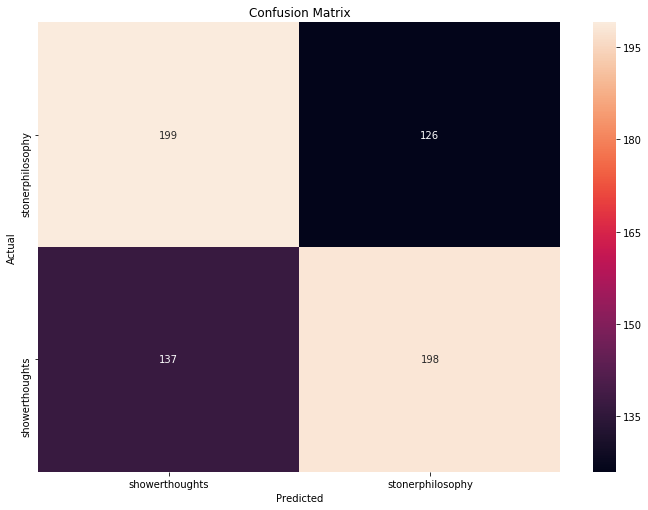

In [84]:
ax= plt.subplot()
hm  = sns.heatmap(confusion1, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks, note stonerphilosophy is coded as 1
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['showerthoughts', 'stonerphilosophy']); ax.yaxis.set_ticklabels(['stonerphilosophy', 'showerthoughts']);
fig1 = hm.get_figure()
fig1.set_size_inches(11.7, 8.27)
fig1.savefig('../Plots/confusion_matrix_mnb.png')

In [85]:
print(f'There were 198 type 1 errors')
print(f'There were 199 type 2 errors')

There were 198 type 1 errors
There were 199 type 2 errors


In [135]:
sens = 126 / (126+199)
spec = 137 / (198+137)

print(f'We have a {sens} sensitivity rate')
print(f'We have a {spec} specificity rate')

We have a 0.38769230769230767 sensitivity rate
We have a 0.408955223880597 specificity rate


I believe this is telling us that we are better at predicting showerthoughts than stonerphilosophy.

In [88]:
pred_proba1 = [i[1] for i in mnb.predict_proba(X2_test)]

pred_df1 = pd.DataFrame({'true_values': y2_test,
                        'pred_probs':pred_proba1})

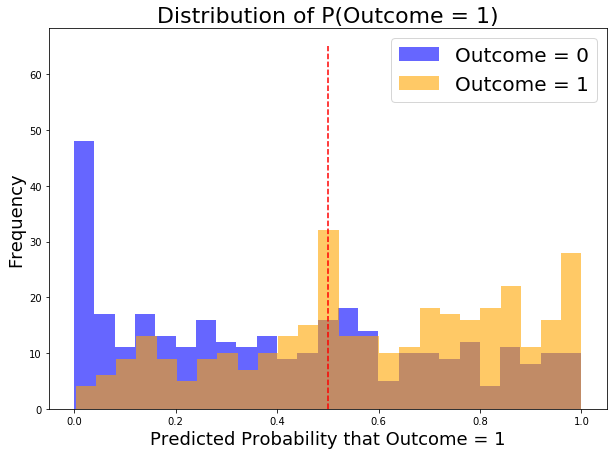

In [89]:
#credit to lecture notes
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df1[pred_df1['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_df1[pred_df1['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

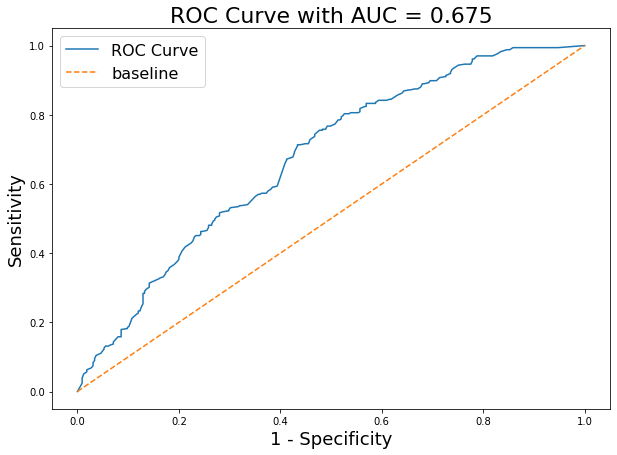

In [92]:
# Create figure. Full credit to lecture notes
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df1, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df1, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df1["true_values"], pred_df1["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16)

plt.savefig('../Plots/roc_auc_mnb.png')

The AUC of the ROC curve is only slightly better than a completely random classifier.

### Model 2: Logistic Regression

In [93]:
coef_df3

,0
000,0.396357
10,-0.272895
100,-0.040167
100 year,-0.269374
11,0.455905
...,...
young,-0.331744
youngest,0.027322
youngest person,0.112017
youtub,-0.233149


In [94]:
coef_df3[0].sort_values(ascending=False).head(15)

would you    1.375900
tri          1.345768
see          1.159008
hors         1.145235
fuck         1.118706
we know      0.948365
hear         0.911718
post         0.906532
smart        0.894096
heaven       0.891605
fractal      0.853380
perspect     0.846886
conscious    0.840468
theori       0.827317
made         0.820511
Name: 0, dtype: float64

In [95]:
coef_df3[0].sort_values(ascending=False).tail(15)

befor           -1.012259
never           -1.021490
chocol          -1.022164
we could        -1.023783
gener           -1.029441
first           -1.035287
thi subreddit   -1.118698
mani            -1.121487
cloth           -1.152463
someon          -1.162056
2020            -1.172715
liter           -1.246506
fart            -1.302182
subreddit       -1.362972
kobe            -1.599552
Name: 0, dtype: float64

In [96]:
print( f'The accuracy score for the logistic training set is {lr.score(X2_train, y2_train)}. \nThe accuracy score for the logistic testing set is {lr.score(X2_test, y2_test)}.')


The accuracy score for the logistic training set is 0.9328358208955224. 
The accuracy score for the logistic testing set is 0.6712121212121213.


In [97]:
#look at actual vs predicted
y_pred2 = lr.predict(X2_test)

In [98]:
results2 = pd.DataFrame(y_pred2, columns=['predicted'])
results2['actual'] = y2_test.to_list()
results2

,predicted,actual
0,0,1
1,0,0
2,0,1
3,0,0
4,1,1
...,...,...
655,0,0
656,1,1
657,1,1
658,0,0


In [99]:
cm(results2['actual'], results2['predicted'])

array([[194, 131],
       [ 86, 249]])

In [100]:
confusion2 = cm(results2['actual'], results2['predicted'])

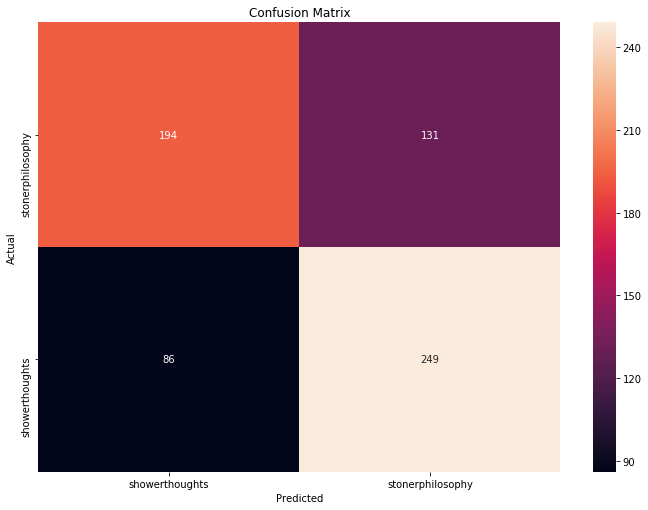

In [101]:
ax= plt.subplot()
hm2 = sns.heatmap(confusion2, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks, note stonerphilosophy is coded as 1
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['showerthoughts', 'stonerphilosophy']); ax.yaxis.set_ticklabels(['stonerphilosophy', 'showerthoughts']);

fig2 = hm2.get_figure()
fig2.set_size_inches(11.7, 8.27)
fig2.savefig('../Plots/confusion_matrix_lr.png')

In [102]:
print(f'There were 249 type 1 errors')
print(f'There were 194 type 2 errors')

There were 249 type 1 errors
There were 194 type 2 errors


In [134]:
sens2 = 131 / (131+194)
spec2 = 86 / (86+249)

print(f'We have a {sens2} sensitivity rate')
print(f'We have a {spec2} specificity rate')

We have a 0.40307692307692305 sensitivity rate
We have a 0.25671641791044775 specificity rate


Actually better at predicting stonerphilosphy now.

In [103]:
pred_proba2 = [i[1] for i in lr.predict_proba(X2_test)]

pred_df2 = pd.DataFrame({'true_values': y2_test,
                        'pred_probs':pred_proba2})

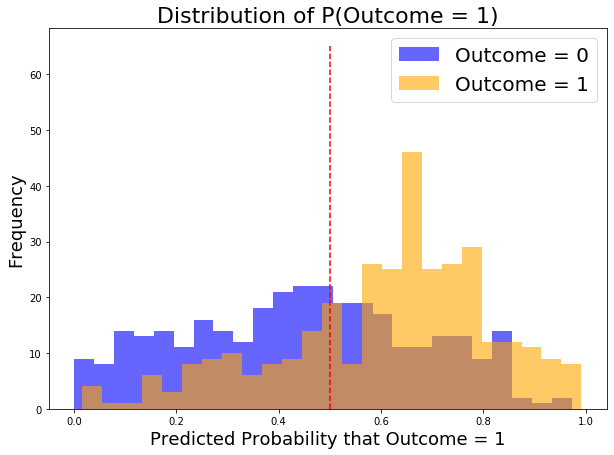

In [104]:
#credit to lecture notes
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df2[pred_df2['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_df2[pred_df2['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

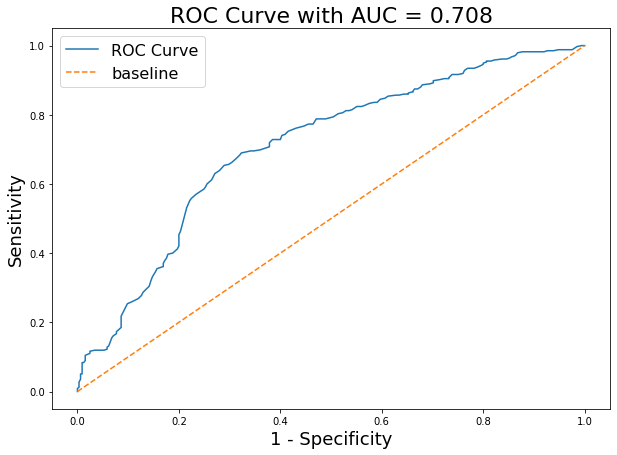

In [105]:
# Create figure. Full credit to lecture notes
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df2, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df2, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df2["true_values"], pred_df2["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);
          
plt.savefig('../Plots/roc_auc_lr.png')

The AUC of the ROC curve is better than the one of our multinomial model. A score of 0.708 tells us that our model classifies better than a random normal one (that would have a 0.5 score) and the multinomial score of 0.675.

In [106]:
results3 = pd.DataFrame(y_pred, columns=['mnb_predicted'])
results3['lr_predicted'] = y_pred2
results3['actual'] = y2_test.to_list()
results3

,mnb_predicted,lr_predicted,actual
0,0,0,1
1,0,0,0
2,0,0,1
3,0,0,0
4,0,1,1
...,...,...,...
655,0,0,0
656,1,1,1
657,0,1,1
658,0,0,0


In [107]:
#Where both models were correct, 346 of these
results3[(results3['mnb_predicted']==results3['lr_predicted']) & (results3['actual']==results3['lr_predicted'])].tail(20)

,mnb_predicted,lr_predicted,actual
623,0,0,0
625,1,1,1
626,1,1,1
628,0,0,0
631,1,1,1
633,1,1,1
637,1,1,1
639,1,1,1
640,1,1,1
643,1,1,1


Correct showerthought

In [108]:
df.iloc[y2_test.index[658],1]

'When you say to somebody "Don\'t tell me what to do", you are telling them what to do.'

In [109]:
df.iloc[y2_test.index[659],1]

'Homer Simpson has had around 200 jobs and his kids have so many problems at age 10 and 8'

Correct stonerphilosophy

In [110]:
df.iloc[y2_test.index[18],1]

"if string theory one day proves that the universe is made out of tiny loops of stringy stuff, do you think that means our entire universe might just be a big tapestry in some gigantic alien's spacemansion?"

In [111]:
df.iloc[y2_test.index[631],1]

'A yodel is just a well-placed voice crack'

In [112]:
#Where both models were wrong, 166 of these
results3[(results3['mnb_predicted']==results3['lr_predicted']) & (results3['actual']!=results3['lr_predicted'])]

,mnb_predicted,lr_predicted,actual
0,0,0,1
2,0,0,1
11,0,0,1
17,1,1,0
22,0,0,1
...,...,...,...
635,1,1,0
636,0,0,1
646,1,1,0
648,0,0,1


Looking at a couple titles that both models got wrong

In [113]:
#predicted  stonerphilosophy but was a showerthought
df.iloc[y2_test.index[635],1]

"If tomatoes are a fruit... Isn't ketchup a smoothie?"

In [114]:
#predicted  stonerphilosophy but was a showerthought
df.iloc[y2_test.index[17],1]

"Peanut butter doesn't get enough credit for how creamy it really is for being made out of legumes."

In [115]:
#predicted showerthought but was a stonerphilosophy
df.iloc[y2_test.index[2],1]

'We’re all up in arms about global warming right now, when we should have caught on a lot sooner since Smash Mouth has been warning us since 1999.'

In [116]:
#predicted showerthought but was a stonerphilosophy
df.iloc[y2_test.index[648],1]

'Airlines could save a lot of money if they could find passengers who are attracted to each other.'

Looking at some titles where the mnb was correct but lr was wrong

In [117]:
#mnb correct, 51 of these
results3[(results3['mnb_predicted']==results3['actual']) & (results3['mnb_predicted']!=results3['lr_predicted'])]

,mnb_predicted,lr_predicted,actual
15,0,1,0
16,0,1,0
26,1,0,1
37,1,0,1
61,0,1,0
75,0,1,0
87,0,1,0
104,0,1,0
120,1,0,1
132,0,1,0


Examples of mnb correct but lr wasn't

In [118]:
df.iloc[y2_test.index[178],1]

"How many pictures am I in the background of a stranger's picture?"

In [119]:
df.iloc[y2_test.index[336],1]

'Some people are scared of automatic subway, but they are just an horizontal elevator.'

Looking at some titles where the lr was correct but mnb was wrong

In [120]:
#mnb correct, 97 of these
results3[(results3['lr_predicted']==results3['actual']) & (results3['mnb_predicted']!=results3['lr_predicted'])]

,mnb_predicted,lr_predicted,actual
4,0,1,1
36,0,1,1
43,1,0,0
48,1,0,0
52,0,1,1
...,...,...,...
627,0,1,1
629,0,1,1
642,1,0,0
653,0,1,1


Examples of lr correct but mnb wasn't.

In [121]:
df.iloc[y2_test.index[52],1]

'Alice in Wonderland was just a story about Alice’s crazy edibles trip'

In [122]:
df.iloc[y2_test.index[36],1]

'The following sentence is false. The preceding sentence is true. '

## Conclusion

If we circle back to our problem statement, we wanted to try to find a model that would best classify between two subreddits. After some exploratory analysis, and various modeling (in the code directory of this repository) we chose to use a multinomial naive bayes and logistic regression model. Surprisingly, the logistic model performs the best with an AUC score of 0.708. We looked at some specific examples where both models predicted correctly, one was wrong, and both were wrong. 

### Future Goals
I tried to add my engineered features of 'word_count' and 'sentiment' but it didn't work.

In [123]:
X_temp = df[['title', 'word_count', 'sentiment']]

In [124]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X_temp, y, test_size = 0.33, random_state =42)

In [125]:
clean_train2 = []
clean_test2 = []

for i in X3_train['title']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_train2.append(pre_processing(i))
    
for i in X3_test['title']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_test2.append(pre_processing(i))

In [126]:
X3_train_a = vectorizer.fit_transform(clean_train2)

X3_test_a = vectorizer.transform(clean_test2)

In [127]:
X3_train_a_df = pd.DataFrame(X3_train_a.toarray(),
                          columns=vectorizer.get_feature_names())
X3_train_a_df

X3_test_a_df = pd.DataFrame(X3_test_a.toarray(),
                          columns=vectorizer.get_feature_names())
X3_test_a_df

,000,10,100,100 year,11,12,13,13 year,15,20,...,you wast,you woke,you world,you would,you you,young,youngest,youngest person,youtub,yr
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
657,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
X3_train[['word_count', 'sentiment']]

,word_count,sentiment
81,7,0.00
915,15,0.06
1018,19,0.10
380,17,0.00
1029,12,0.00
...,...,...
1130,26,-0.07
1294,3,0.00
860,25,0.00
1459,9,0.00


In [129]:
X3_train_a_df['word_count'] = X3_train['word_count'].to_list()
X3_train_a_df['sentiment'] = X3_train['sentiment'].to_list()
X3_train_a_df

,000,10,100,100 year,11,12,13,13 year,15,20,...,you world,you would,you you,young,youngest,youngest person,youtub,yr,word_count,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0.00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,0.06
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,19,0.10
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,17,0.00
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,26,-0.07
1336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0.00
1337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0.00
1338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0.00


In [130]:
X3_test_a_df['word_count'] = X3_test['word_count'].to_list()
X3_test_a_df['sentiment'] = X3_test['sentiment'].to_list()
X3_test_a_df

,000,10,100,100 year,11,12,13,13 year,15,20,...,you world,you would,you you,young,youngest,youngest person,youtub,yr,word_count,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,0.00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0.00
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,28,0.00
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,24,-0.04
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,0.00
656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,0.00
657,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.00
658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,18,0.00


In [131]:
mnb2 = MultinomialNB()

In [132]:
mnb2.fit(X3_train_a_df, X3_test_a_df)

ValueError: bad input shape (660, 1782)

In [ ]:
lr2 = LogisticRegression()

In [ ]:
lr2.fit(X3_train_a_df, X3_test_a_df)